# NCAA March Madness (MoneyBall edition)
### This notebook will cover the complete process of building a classifier machine learning model to predict the win probability of each matchup in the 2018 NCAA March Madness Tournament.
### There are three major milestones:
1. Create training and test datasets
2. Create a machine learning model and train using the training set
3. Test the model using the test sets and create a submission file for Stage 1 of the Kaggle competition
4. Update datasets with 2018 data and create predictions for the 2018 NCAA March Madness Tournament

## Part 1: Creating the training/test set
### The dataset is generated from the following features:
* [The Four Factors](https://www.nbastuffer.com/analytics101/four-factors/)
* [Player Impact Estimate (PIE)](https://masseybasketball.blogspot.com/2013/07/player-impact-estimate.html)
* [Offensive Efficiency](https://www.nbastuffer.com/analytics101/offensive-efficiency/)
* [Defensive Efficiency](https://www.nbastuffer.com/analytics101/defensive-efficiency/)
* [Defensive Rebounding Percentage](https://www.nbastuffer.com/analytics101/defensive-rebounding-percentage/)
* [Assist Ratio](https://www.nbastuffer.com/analytics101/assist-ratio/)
* Free Throw Percentage
* Score Differential
* [Rating Percentage Index (RPI)](https://en.wikipedia.org/wiki/Rating_Percentage_Index)
* Tournament Seed
* Win Percentage

#### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, metrics, svm, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

pd.set_option('display.max_columns', 999)

#### Load Data Files

In [2]:
df_tourney = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
df_season = pd.read_csv('RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv('Teams.csv')
df_kenpom = pd.read_csv('KenPom.csv')
df_seeds = pd.read_csv('NCAATourneySeeds.csv')
# df_conferences = pd.read_csv('DataFiles/Conferences.csv')
# df_rankings = pd.read_csv('MasseyOrdinals.csv')
df_rankings = pd.read_csv('MasseyOrdinals_thruSeason2018_Day128.csv')
# df_sample_sub = pd.read_csv('SampleSubmissionStage1.csv')
df_sample_sub = pd.read_csv('SampleSubmissionStage2.csv')

# df_tourney = pd.read_csv('../input/NCAATourneyCompactResults.csv')
# df_season = pd.read_csv('../input/RegularSeasonDetailedResults.csv')
# df_teams = pd.read_csv('../input/Teams.csv')
# df_seeds = pd.read_csv('../input/NCAATourneySeeds.csv')
# df_conferences = pd.read_csv('../input/Conferences.csv')
# df_rankings = pd.read_csv('../input/MasseyOrdinals.csv')
# df_rankings = pd.read_csv('../input/MasseyOrdinals_thruSeason2018_Day128.csv')
# df_sample_sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
# df_sample_sub = pd.read_csv('../input/SampleSubmissionStage2.csv')

In [3]:
df_kenpom['TeamID'] = df_kenpom['TeamName'].apply(lambda x: df_teams[df_teams['TeamName'] == x].values[0][0])

### Calculate Winning/losing Team Possesion Feature
[Possession](https://www.nbastuffer.com/analytics101/possession/)
#### Formula=0.96*(Field Goal Attempts + Turnovers + 0.44*Free Throw Attempts - Offensive Rebounds)

In [4]:
# Calculate possesion for each team then take the average

wPos = df_season.apply(lambda row: 0.96*(row.WFGA + row.WTO + 0.44*row.WFTA - row.WOR), axis=1)
lPos = df_season.apply(lambda row: 0.96*(row.LFGA + row.LTO + 0.44*row.LFTA - row.LOR), axis=1)

df_season['POSS'] = (wPos + lPos) / 2

### Player Impact Estimate
#### Formula (PTS + FGM + FTM - FGA - FTA + DREB + .5 * OREB + AST + STL + .5 * BLK - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + .5 * GmOREB + GmAST + GmSTL + .5 * GmBLK - GmPF – GmTO)

In [5]:
wPIE = df_season.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + 0.5*row.WOR + row.WAst + row.WStl + 0.5*row.WBlk - row.WPF - row.WTO, axis=1)
lPIE = df_season.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + 0.5*row.LOR + row.LAst + row.LStl + 0.5*row.LBlk - row.LPF - row.LTO, axis=1)

df_season['WPIE'] = wPIE / (wPIE + lPIE)
df_season['LPIE'] = lPIE / (wPIE + lPIE)

### Calculate Four Factors

In [6]:
# Effective Field Goal Percentage= (Field Goals Made + 0.5*3P Field Goals Made) / Field Goal Attempts
df_season['WeFGP'] = df_season.apply(lambda row: (row.WFGM + 0.5*row.WFGM3) / row.WFGA, axis=1)
df_season['LeFGP'] = df_season.apply(lambda row: (row.LFGM + 0.5*row.LFGM3) / row.LFGA, axis=1)

# Turnover Rate= Turnovers/(Field Goal Attempts + 0.44*Free Throw Attempts + Turnovers)
df_season['WToR'] = df_season.apply(lambda row: row.WTO / (row.WFGA + 0.44*row.WFTA + row.WTO), axis=1)
df_season['LToR'] = df_season.apply(lambda row: row.LTO / (row.LFGA + 0.44*row.LFTA + row.LTO), axis=1)

# Offensive Rebounding Percentage = Offensive Rebounds / (Offensive Rebounds + Opponent’s Defensive Rebounds)
df_season['WORP'] = df_season.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_season['LORP'] = df_season.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)

# Free Throw Rate= Free Throws Made / Field Goals Attempted or Free Throws Attempted/Field Goals Attempted
df_season['WFTR'] = df_season.apply(lambda row: row.WFTA / row.WFGA, axis=1)
df_season['LFTR'] = df_season.apply(lambda row: row.LFTA / row.LFGA, axis=1)

# 4 Factors is weighted as follows
# 1. Shooting (40%)
# 2. Turnovers (25%)
# 3. Rebounding (20%)
# 4. Free Throws (15%)

df_season['W4Factor'] = df_season.apply(lambda row: 0.4*row.WeFGP + 0.25*row.WToR + 0.2*row.WORP + 0.15*row.WFTR, axis=1)
df_season['L4Factor'] = df_season.apply(lambda row: 0.4*row.LeFGP + 0.25*row.LToR + 0.2*row.LORP + 0.15*row.LFTR, axis=1)

In [7]:
def getAdjO(Year, TeamID):
    try:
        AdjO = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][2]
    except IndexError:
        AdjO = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[1].round(2)
    return AdjO

def getAdjD(Year, TeamID):
    try:
        AdjD = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][3]
    except IndexError:
        AdjD = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[2].round(2)
    return AdjD

def getAdjEM(Year, TeamID):
    try:
        AdjEM = df_kenpom[(df_kenpom['TeamID'] == TeamID) & (df_kenpom['Season'] == Year)].values[0][4]
    except IndexError:
        AdjEM = df_kenpom[df_kenpom['TeamID'] == TeamID].mean().values[3].round(2)
    return AdjEM

In [8]:
# Offensive efficiency (OffRtg) =  Points / Possessions
# df_season['WOE'] = df_season.apply(lambda row: row.WScore / row.POSS, axis=1)
# df_season['LOE'] = df_season.apply(lambda row: row.LScore / row.POSS, axis=1)

# Adjusted Offensive Efficiency
df_season['WAdjO'] = df_season.apply(lambda row: getAdjO(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjO'] = df_season.apply(lambda row: getAdjO(row['Season'], row['LTeamID']), axis=1)

# Defensive efficiency (DefRtg) = Opponent points / Opponent possessions
# df_season['WDE'] = df_season.apply(lambda row: row.LScore / row.POSS, axis=1)
# df_season['LDE'] = df_season.apply(lambda row: row.WScore / row.POSS, axis=1)

# Adjusted Defensive Efficiency
df_season['WAdjD'] = df_season.apply(lambda row: getAdjD(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjD'] = df_season.apply(lambda row: getAdjD(row['Season'], row['LTeamID']), axis=1)

# Adjusted Efficiency Margin
df_season['WAdjEM'] = df_season.apply(lambda row: getAdjEM(row['Season'], row['WTeamID']), axis=1)
df_season['LAdjEM'] = df_season.apply(lambda row: getAdjEM(row['Season'], row['LTeamID']), axis=1)

# Defensive Rebounding Percentage = Defensive Rebounds / (Defensive Rebounds + Opponents Offensive Rebounds)
df_season['WDRP'] = df_season.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_season['LDRP'] = df_season.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)

# Offensive Rebound to Turnover Margin
df_season['WORTM'] = df_season.apply(lambda row: row.WOR - row.WTO, axis=1)
df_season['LORTM'] = df_season.apply(lambda row: row.LOR - row.LTO, axis=1)

# Assist Ratio = Assists/ (Field Goal Attempts + Free Throw Attempts*0.44 + Assists + Turnovers)
df_season['WAR'] = df_season.apply(lambda row: row.WAst / (row.WFGA + row.WFTA*0.44 + row.WAst + row.WTO), axis=1)
df_season['LAR'] = df_season.apply(lambda row: row.LAst / (row.LFGA + row.LFTA*0.44 + row.LAst + row.LTO), axis=1)

# Free Throw Percentage
df_season['WFTP'] = df_season.apply(lambda row: 0.0 if row.WFTA == 0 else row.WFTM / row.WFTA, axis=1)
df_season['LFTP'] = df_season.apply(lambda row: 0.0 if row.LFTA == 0 else row.LFTM / row.LFTA, axis=1)

# Score Differential = Points scored - points allowed
df_season['WPtsDf'] = df_season.apply(lambda row: row.WScore - row.LScore, axis=1)
df_season['LPtsDf'] = df_season.apply(lambda row: row.LScore - row.WScore, axis=1)

### Drop "normal" stats columns

In [9]:
df_season.drop(labels=['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1, inplace=True)
df_season.drop(labels=['LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

In [10]:
df_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,POSS,WPIE,LPIE,WeFGP,LeFGP,WToR,LToR,WORP,LORP,WFTR,LFTR,W4Factor,L4Factor,WAdjO,LAdjO,WAdjD,LAdjD,WAdjEM,LAdjEM,WDRP,LDRP,WORTM,LORTM,WAR,LAR,WFTP,LFTP,WPtsDf,LPtsDf
0,2003,10,1104,68,1328,62,N,0,69.8880,0.532847,0.467153,0.491379,0.433962,0.258659,0.223104,0.388889,0.294118,0.310345,0.415094,0.385546,0.350448,110.3,112.1,95.7,89.1,14.60,23.01,0.705882,0.611111,-9,-8,0.127551,0.090212,0.611111,0.727273,6,-6
1,2003,10,1272,70,1393,63,N,0,65.3568,0.602339,0.397661,0.483871,0.402985,0.155950,0.136674,0.375000,0.416667,0.306452,0.298507,0.353504,0.323472,110.9,114.4,94.1,91.1,16.72,23.28,0.583333,0.625000,2,8,0.161031,0.073840,0.526316,0.450000,7,-7
2,2003,11,1266,73,1437,61,N,0,61.3824,0.736434,0.263566,0.482759,0.321918,0.123824,0.126156,0.435897,0.543860,0.500000,0.315068,0.386239,0.316338,120.5,106.6,99.2,95.4,21.30,11.17,0.456140,0.564103,7,19,0.156642,0.086439,0.586207,0.608696,12,-12
3,2003,11,1296,56,1457,50,N,0,55.3152,0.754717,0.245283,0.513158,0.428571,0.188561,0.254692,0.230769,0.472222,0.815789,0.306122,0.420926,0.375464,104.6,97.1,102.1,102.9,2.52,-5.81,0.527778,0.769231,-6,-2,0.147374,0.107656,0.548387,0.533333,6,-6
4,2003,11,1400,77,1208,71,N,0,60.7680,0.570732,0.429268,0.540984,0.435484,0.173439,0.119218,0.531250,0.488372,0.213115,0.435484,0.397970,0.366995,119.3,120.9,95.8,99.9,23.49,20.93,0.511628,0.468750,3,11,0.129422,0.125156,0.846154,0.629630,6,-6


### Calculate aggregate games  into season totals for each team

In [11]:
df_season_totals = pd.DataFrame()

# Calculate wins and losses to get winning percentage
df_season_totals['Wins'] = df_season['WTeamID'].groupby([df_season['Season'], df_season['WTeamID']]).count()
df_season_totals['Losses'] = df_season['LTeamID'].groupby([df_season['Season'], df_season['LTeamID']]).count()
df_season_totals['WinPCT'] = df_season_totals['Wins'] / (df_season_totals['Wins'] + df_season_totals['Losses'])

# Calculate averages for games team won
# df_season_totals['WFGM'] = df_season['WFGM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFGA'] = df_season['WFGA'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFGM3'] = df_season['WFGM3'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFGA3'] = df_season['WFGA3'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFTM'] = df_season['WFTM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFTA'] = df_season['WFTA'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WOR'] = df_season['WOR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WDR'] = df_season['WDR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WAst'] = df_season['WAst'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WTO'] = df_season['WTO'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WStl'] = df_season['WStl'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WBlk'] = df_season['WBlk'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WPF'] = df_season['WPF'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WPIE'] = df_season['WPIE'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['WFGP'] = df_season['WFGP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['W3FGP'] = df_season['W3FGP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WeFGP'] = df_season['WeFGP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WToR'] = df_season['WToR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WORP'] = df_season['WORP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WFTR'] = df_season['WFTR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['W4Factor'] = df_season['W4Factor'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjO'] = df_season['WAdjO'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjD'] = df_season['WAdjD'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAdjEM'] = df_season['WAdjEM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WDRP'] = df_season['WDRP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WORTM'] = df_season['WORTM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WAR'] = df_season['WAR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WFTP'] = df_season['WFTP'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['WPtsDf'] = df_season['WPtsDf'].groupby([df_season['Season'], df_season['WTeamID']]).mean()

# Calculate averages for games team lost
# df_season_totals['LFGM'] = df_season['LFGM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFGA'] = df_season['LFGA'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFGM3'] = df_season['LFGM3'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFGA3'] = df_season['LFGA3'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFTM'] = df_season['LFTM'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LFTA'] = df_season['LFTA'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LOR'] = df_season['LOR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LDR'] = df_season['LDR'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LAst'] = df_season['LAst'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LTO'] = df_season['LTO'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LStl'] = df_season['LStl'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LBlk'] = df_season['LBlk'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
# df_season_totals['LPF'] = df_season['LPF'].groupby([df_season['Season'], df_season['WTeamID']]).mean()
df_season_totals['LPIE'] = df_season['LPIE'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
# df_season_totals['LFGP'] = df_season['LFGP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
# df_season_totals['L3FGP'] = df_season['L3FGP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LeFGP'] = df_season['LeFGP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LToR'] = df_season['LToR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LORP'] = df_season['LORP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LFTR'] = df_season['LFTR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['L4Factor'] = df_season['L4Factor'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjO'] = df_season['LAdjO'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjD'] = df_season['LAdjD'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAdjEM'] = df_season['LAdjEM'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LDRP'] = df_season['LDRP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LORTM'] = df_season['LORTM'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LAR'] = df_season['LAR'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LFTP'] = df_season['LFTP'].groupby([df_season['Season'], df_season['LTeamID']]).mean()
df_season_totals['LPtsDf'] = df_season['LPtsDf'].groupby([df_season['Season'], df_season['LTeamID']]).mean()

# Calculate weighted average using winning percent to weigh the statistic
# df_season_totals['FGM'] = df_season_totals['WFGM']*df_season_totals['WinPCT'] + df_season_totals['LFGM']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FGA'] = df_season_totals['WFGA']*df_season_totals['WinPCT'] + df_season_totals['LFGA']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FGM3'] = df_season_totals['WFGM3']*df_season_totals['WinPCT'] + df_season_totals['LFGM3']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FGA3'] = df_season_totals['WFGA3']*df_season_totals['WinPCT'] + df_season_totals['LFGA3']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FTM'] = df_season_totals['WFTM']*df_season_totals['WinPCT'] + df_season_totals['LFTM']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FTA'] = df_season_totals['WFTA']*df_season_totals['WinPCT'] + df_season_totals['LFTA']*(1 - df_season_totals['WinPCT'])
# df_season_totals['OR'] = df_season_totals['WOR']*df_season_totals['WinPCT'] + df_season_totals['LOR']*(1 - df_season_totals['WinPCT'])
# df_season_totals['DR'] = df_season_totals['WDR']*df_season_totals['WinPCT'] + df_season_totals['LDR']*(1 - df_season_totals['WinPCT'])
# df_season_totals['Ast'] = df_season_totals['WAst']*df_season_totals['WinPCT'] + df_season_totals['LAst']*(1 - df_season_totals['WinPCT'])
# df_season_totals['TO'] = df_season_totals['WTO']*df_season_totals['WinPCT'] + df_season_totals['LTO']*(1 - df_season_totals['WinPCT'])
# df_season_totals['Stl'] = df_season_totals['WStl']*df_season_totals['WinPCT'] + df_season_totals['LStl']*(1 - df_season_totals['WinPCT'])
# df_season_totals['Blk'] = df_season_totals['WBlk']*df_season_totals['WinPCT'] + df_season_totals['LBlk']*(1 - df_season_totals['WinPCT'])
# df_season_totals['PF'] = df_season_totals['WPF']*df_season_totals['WinPCT'] + df_season_totals['LPF']*(1 - df_season_totals['WinPCT'])
df_season_totals['PIE'] = df_season_totals['WPIE']*df_season_totals['WinPCT'] + df_season_totals['LPIE']*(1 - df_season_totals['WinPCT'])
df_season_totals['eFGP'] = df_season_totals['WeFGP']*df_season_totals['WinPCT'] + df_season_totals['LeFGP']*(1 - df_season_totals['WinPCT'])
# df_season_totals['FGP'] = df_season_totals['WFGP']*df_season_totals['WinPCT'] + df_season_totals['LFGP']*(1 - df_season_totals['WinPCT'])
# df_season_totals['3FGP'] = df_season_totals['W3FGP']*df_season_totals['WinPCT'] + df_season_totals['L3FGP']*(1 - df_season_totals['WinPCT'])
df_season_totals['ToR'] = df_season_totals['WToR']*df_season_totals['WinPCT'] + df_season_totals['LToR']*(1 - df_season_totals['WinPCT'])
df_season_totals['ORP'] = df_season_totals['WORP']*df_season_totals['WinPCT'] + df_season_totals['LORP']*(1 - df_season_totals['WinPCT'])
df_season_totals['FTR'] = df_season_totals['WFTR']*df_season_totals['WinPCT'] + df_season_totals['LFTR']*(1 - df_season_totals['WinPCT'])
df_season_totals['4Factor'] = df_season_totals['W4Factor']*df_season_totals['WinPCT'] + df_season_totals['L4Factor']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjO'] = df_season_totals['WAdjO']*df_season_totals['WinPCT'] + df_season_totals['LAdjO']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjD'] = df_season_totals['WAdjD']*df_season_totals['WinPCT'] + df_season_totals['LAdjD']*(1 - df_season_totals['WinPCT'])
df_season_totals['AdjEM'] = df_season_totals['WAdjEM']*df_season_totals['WinPCT'] + df_season_totals['LAdjEM']*(1 - df_season_totals['WinPCT'])
df_season_totals['DRP'] = df_season_totals['WDRP']*df_season_totals['WinPCT'] + df_season_totals['LDRP']*(1 - df_season_totals['WinPCT'])
df_season_totals['ORTM'] = df_season_totals['WORTM']*df_season_totals['WinPCT'] + df_season_totals['LORTM']*(1 - df_season_totals['WinPCT'])
df_season_totals['AR'] = df_season_totals['WAR']*df_season_totals['WinPCT'] + df_season_totals['LAR']*(1 - df_season_totals['WinPCT'])
df_season_totals['FTP'] = df_season_totals['WFTP']*df_season_totals['WinPCT'] + df_season_totals['LFTP']*(1 - df_season_totals['WinPCT'])
df_season_totals['PtsDf'] = df_season_totals['WPtsDf']*df_season_totals['WinPCT'] + df_season_totals['LPtsDf']*(1 - df_season_totals['WinPCT'])

df_season_totals.reset_index(inplace=True)

In [12]:
df_season_totals.head()

,Season,WTeamID,Wins,Losses,WinPCT,WPIE,WeFGP,WToR,WORP,WFTR,W4Factor,WAdjO,WAdjD,WAdjEM,WDRP,WORTM,WAR,WFTP,WPtsDf,LPIE,LeFGP,LToR,LORP,LFTR,L4Factor,LAdjO,LAdjD,LAdjEM,LDRP,LORTM,LAR,LFTP,LPtsDf,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf
0,2003,1102,12,16.0,0.428571,0.755263,0.692162,0.182036,0.172188,0.541714,0.438068,105.2,104.0,1.27,0.636526,-7.250000,0.218356,0.631688,15.583333,0.288600,0.503591,0.201436,0.165271,0.375427,0.341164,105.2,104.0,1.27,0.625778,-7.250000,0.147840,0.650437,-11.250000,0.488599,0.584407,0.193121,0.168235,0.446693,0.382694,105.2,104.0,1.27,0.630384,-7.250000,0.178061,0.642402,0.250000
1,2003,1103,13,14.0,0.481481,0.615446,0.592604,0.155195,0.318510,0.554488,0.422715,110.0,110.9,-0.92,0.620109,-3.153846,0.178446,0.722603,9.384615,0.411540,0.484527,0.164085,0.294003,0.382163,0.350957,110.0,110.9,-0.92,0.633394,-2.571429,0.141322,0.747034,-7.500000,0.509717,0.536564,0.159805,0.305803,0.465135,0.385508,110.0,110.9,-0.92,0.626998,-2.851852,0.159196,0.735271,0.629630
2,2003,1104,17,11.0,0.607143,0.657820,0.506056,0.160278,0.367049,0.392488,0.374775,110.3,95.7,14.60,0.703299,0.470588,0.147173,0.709384,13.176471,0.349042,0.429002,0.178087,0.377756,0.341227,0.342858,110.3,95.7,14.60,0.661550,0.000000,0.105963,0.698651,-9.454545,0.536514,0.475785,0.167275,0.371256,0.372350,0.362236,110.3,95.7,14.60,0.686897,0.285714,0.130983,0.705168,4.285714
3,2003,1105,7,19.0,0.269231,0.641277,0.488400,0.197495,0.383144,0.425332,0.385163,90.0,108.2,-18.25,0.667596,-3.428571,0.147308,0.743782,13.000000,0.331704,0.446777,0.211586,0.317489,0.335248,0.345392,90.0,108.2,-18.25,0.631796,-5.789474,0.134965,0.697004,-11.473684,0.415050,0.457983,0.207792,0.335166,0.359501,0.356100,90.0,108.2,-18.25,0.641434,-5.153846,0.138288,0.709598,-4.884615
4,2003,1106,13,15.0,0.464286,0.741382,0.517668,0.220207,0.378952,0.395797,0.397279,90.9,100.9,-9.95,0.714061,-4.923077,0.137635,0.591138,10.384615,0.342262,0.450522,0.208100,0.323938,0.231093,0.331685,90.9,100.9,-9.95,0.649253,-4.600000,0.116900,0.650908,-9.266667,0.527568,0.481697,0.213721,0.349480,0.307563,0.362140,90.9,100.9,-9.95,0.679342,-4.750000,0.126527,0.623158,-0.142857


### Identify null values

In [13]:
df_season_totals[pd.isnull(df_season_totals['Losses'])]

,Season,WTeamID,Wins,Losses,WinPCT,WPIE,WeFGP,WToR,WORP,WFTR,W4Factor,WAdjO,WAdjD,WAdjEM,WDRP,WORTM,WAR,WFTP,WPtsDf,LPIE,LeFGP,LToR,LORP,LFTR,L4Factor,LAdjO,LAdjD,LAdjEM,LDRP,LORTM,LAR,LFTP,LPtsDf,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf
4064,2014,1455,33,NaN,NaN,0.697612,0.523191,0.137994,0.353977,0.479304,0.386466,117.8,92.4,25.36,0.74727,1.424242,0.149764,0.731159,15.060606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4211,2015,1246,34,NaN,NaN,0.809886,0.520134,0.137713,0.402745,0.451499,0.390756,121.3,84.4,36.91,0.68447,2.294118,0.158968,0.719838,20.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Replace null values with actual values

In [14]:
df_season_totals.loc[4064, 'Losses'] = 0
df_season_totals.loc[4064, 'WinPCT'] = 1
# df_season_totals.loc[4064, 'FGM'] = df_season_totals.loc[4064, 'WFGM']
# df_season_totals.loc[4064, 'FGA'] = df_season_totals.loc[4064, 'WFGA']
# df_season_totals.loc[4064, 'FGM3'] = df_season_totals.loc[4064, 'WFGM3']
# df_season_totals.loc[4064, 'FGA3'] = df_season_totals.loc[4064, 'WFGA3']
# df_season_totals.loc[4064, 'FTM'] = df_season_totals.loc[4064, 'WFTM']
# df_season_totals.loc[4064, 'FTA'] = df_season_totals.loc[4064, 'WFTA']
# df_season_totals.loc[4064, 'OR'] = df_season_totals.loc[4064, 'WOR']
# df_season_totals.loc[4064, 'DR'] = df_season_totals.loc[4064, 'WDR']
# df_season_totals.loc[4064, 'Ast'] = df_season_totals.loc[4064, 'WAst']
# df_season_totals.loc[4064, 'TO'] = df_season_totals.loc[4064, 'WTO']
# df_season_totals.loc[4064, 'Stl'] = df_season_totals.loc[4064, 'WStl']
# df_season_totals.loc[4064, 'Blk'] = df_season_totals.loc[4064, 'WBlk']
# df_season_totals.loc[4064, 'PF'] = df_season_totals.loc[4064, 'WPF']
# df_season_totals.loc[4064, 'FGP'] = df_season_totals.loc[4064, 'WFGP']
# df_season_totals.loc[4064, '3FGP'] = df_season_totals.loc[4064, 'W3FGP']
df_season_totals.loc[4064, 'PIE'] = df_season_totals.loc[4064, 'WPIE']
df_season_totals.loc[4064, 'eFGP'] = df_season_totals.loc[4064, 'WeFGP']
df_season_totals.loc[4064, 'ToR'] = df_season_totals.loc[4064, 'WToR']
df_season_totals.loc[4064, 'ORP'] = df_season_totals.loc[4064, 'WORP']
df_season_totals.loc[4064, 'FTR'] = df_season_totals.loc[4064, 'WFTR']
df_season_totals.loc[4064, '4Factor'] = df_season_totals.loc[4064, 'W4Factor']
df_season_totals.loc[4064, 'AdjO'] = df_season_totals.loc[4064, 'WAdjO']
df_season_totals.loc[4064, 'AdjD'] = df_season_totals.loc[4064, 'WAdjD']
df_season_totals.loc[4064, 'AdjEM'] = df_season_totals.loc[4064, 'WAdjEM']
df_season_totals.loc[4064, 'DRP'] = df_season_totals.loc[4064, 'WDRP']
df_season_totals.loc[4064, 'ORTM'] = df_season_totals.loc[4064, 'WORTM']
df_season_totals.loc[4064, 'AR'] = df_season_totals.loc[4064, 'WAR']
df_season_totals.loc[4064, 'FTP'] = df_season_totals.loc[4064, 'WFTP']
df_season_totals.loc[4064, 'PtsDf'] = df_season_totals.loc[4064, 'WPtsDf']

df_season_totals.loc[4211, 'Losses'] = 0
df_season_totals.loc[4211, 'WinPCT'] = 1
# df_season_totals.loc[4211, 'FGM'] = df_season_totals.loc[4211, 'WFGM']
# df_season_totals.loc[4211, 'FGA'] = df_season_totals.loc[4211, 'WFGA']
# df_season_totals.loc[4211, 'FGM3'] = df_season_totals.loc[4211, 'WFGM3']
# df_season_totals.loc[4211, 'FGA3'] = df_season_totals.loc[4211, 'WFGA3']
# df_season_totals.loc[4211, 'FTM'] = df_season_totals.loc[4211, 'WFTM']
# df_season_totals.loc[4211, 'FTA'] = df_season_totals.loc[4211, 'WFTA']
# df_season_totals.loc[4211, 'OR'] = df_season_totals.loc[4211, 'WOR']
# df_season_totals.loc[4211, 'DR'] = df_season_totals.loc[4211, 'WDR']
# df_season_totals.loc[4211, 'Ast'] = df_season_totals.loc[4211, 'WAst']
# df_season_totals.loc[4211, 'TO'] = df_season_totals.loc[4211, 'WTO']
# df_season_totals.loc[4211, 'Stl'] = df_season_totals.loc[4211, 'WStl']
# df_season_totals.loc[4211, 'Blk'] = df_season_totals.loc[4211, 'WBlk']
# df_season_totals.loc[4211, 'PF'] = df_season_totals.loc[4211, 'WPF']
# df_season_totals.loc[4211, 'FGP'] = df_season_totals.loc[4211, 'WFGP']
# df_season_totals.loc[4211, '3FGP'] = df_season_totals.loc[4211, 'W3FGP']
df_season_totals.loc[4211, 'PIE'] = df_season_totals.loc[4211, 'WPIE']
df_season_totals.loc[4211, 'eFGP'] = df_season_totals.loc[4211, 'WeFGP']
df_season_totals.loc[4211, 'ToR'] = df_season_totals.loc[4211, 'WToR']
df_season_totals.loc[4211, 'ORP'] = df_season_totals.loc[4211, 'WORP']
df_season_totals.loc[4211, 'FTR'] = df_season_totals.loc[4211, 'WFTR']
df_season_totals.loc[4211, '4Factor'] = df_season_totals.loc[4211, 'W4Factor']
df_season_totals.loc[4211, 'AdjO'] = df_season_totals.loc[4211, 'WAdjO']
df_season_totals.loc[4211, 'AdjD'] = df_season_totals.loc[4211, 'WAdjD']
df_season_totals.loc[4211, 'AdjEM'] = df_season_totals.loc[4211, 'WAdjEM']
df_season_totals.loc[4211, 'DRP'] = df_season_totals.loc[4211, 'WDRP']
df_season_totals.loc[4211, 'ORTM'] = df_season_totals.loc[4211, 'WORTM']
df_season_totals.loc[4211, 'AR'] = df_season_totals.loc[4211, 'WAR']
df_season_totals.loc[4211, 'FTP'] = df_season_totals.loc[4211, 'WFTP']
df_season_totals.loc[4211, 'PtsDf'] = df_season_totals.loc[4211, 'WPtsDf']

### Keep only summary statistics

In [15]:
df_season_totals.columns

Index(['Season', 'WTeamID', 'Wins', 'Losses', 'WinPCT', 'WPIE', 'WeFGP',
       'WToR', 'WORP', 'WFTR', 'W4Factor', 'WAdjO', 'WAdjD', 'WAdjEM', 'WDRP',
       'WORTM', 'WAR', 'WFTP', 'WPtsDf', 'LPIE', 'LeFGP', 'LToR', 'LORP',
       'LFTR', 'L4Factor', 'LAdjO', 'LAdjD', 'LAdjEM', 'LDRP', 'LORTM', 'LAR',
       'LFTP', 'LPtsDf', 'PIE', 'eFGP', 'ToR', 'ORP', 'FTR', '4Factor', 'AdjO',
       'AdjD', 'AdjEM', 'DRP', 'ORTM', 'AR', 'FTP', 'PtsDf'],
      dtype='object')

In [16]:
df_season_totals.drop(labels=['Wins', 'Losses', 'WPIE', 'WeFGP', 'WToR', 'WORP', 'WFTR', 'W4Factor', 'WAdjO', 'WAdjD',
                              'WAdjEM', 'WDRP', 'WORTM', 'WAR', 'WFTP', 'WPtsDf', 'LPIE', 'LeFGP', 'LToR', 'LORP', 'LFTR',
                              'L4Factor', 'LAdjO', 'LAdjD', 'LAdjEM', 'LDRP', 'LORTM', 'LAR', 'LFTP', 'LPtsDf'],
                      axis=1, inplace=True)

In [17]:
df_season_totals.head()

,Season,WTeamID,WinPCT,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf
0,2003,1102,0.428571,0.488599,0.584407,0.193121,0.168235,0.446693,0.382694,105.2,104.0,1.27,0.630384,-7.250000,0.178061,0.642402,0.250000
1,2003,1103,0.481481,0.509717,0.536564,0.159805,0.305803,0.465135,0.385508,110.0,110.9,-0.92,0.626998,-2.851852,0.159196,0.735271,0.629630
2,2003,1104,0.607143,0.536514,0.475785,0.167275,0.371256,0.372350,0.362236,110.3,95.7,14.60,0.686897,0.285714,0.130983,0.705168,4.285714
3,2003,1105,0.269231,0.415050,0.457983,0.207792,0.335166,0.359501,0.356100,90.0,108.2,-18.25,0.641434,-5.153846,0.138288,0.709598,-4.884615
4,2003,1106,0.464286,0.527568,0.481697,0.213721,0.349480,0.307563,0.362140,90.9,100.9,-9.95,0.679342,-4.750000,0.126527,0.623158,-0.142857


### Reorganize column headers and rename WTeamID to TeamID

In [18]:
columns = df_season_totals.columns.tolist()
columns.pop(2)
columns.append('WinPCT')
df_season_totals = df_season_totals[columns]
df_season_totals.rename(columns={'WTeamID': 'TeamID'}, inplace=True)
df_season_totals.head()

,Season,TeamID,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,2003,1102,0.488599,0.584407,0.193121,0.168235,0.446693,0.382694,105.2,104.0,1.27,0.630384,-7.250000,0.178061,0.642402,0.250000,0.428571
1,2003,1103,0.509717,0.536564,0.159805,0.305803,0.465135,0.385508,110.0,110.9,-0.92,0.626998,-2.851852,0.159196,0.735271,0.629630,0.481481
2,2003,1104,0.536514,0.475785,0.167275,0.371256,0.372350,0.362236,110.3,95.7,14.60,0.686897,0.285714,0.130983,0.705168,4.285714,0.607143
3,2003,1105,0.415050,0.457983,0.207792,0.335166,0.359501,0.356100,90.0,108.2,-18.25,0.641434,-5.153846,0.138288,0.709598,-4.884615,0.269231
4,2003,1106,0.527568,0.481697,0.213721,0.349480,0.307563,0.362140,90.9,100.9,-9.95,0.679342,-4.750000,0.126527,0.623158,-0.142857,0.464286


### Strength of Schedule
#### Use RPI Ranking
#### Rating Percentage Index (RPI) Formula=.25(Team’s Winning Percentage)+.50(Opponents’ Average Winning Percentage)+0.25*(Opponents’ Opponents’ Average Winning Percentage)
#### Use the final pre-tournament rankings each year (RankingDayNum of 133)

In [19]:
df_rpi = df_rankings[df_rankings['SystemName'] == 'RPI']
df_rpi_2018 = df_rpi[df_rpi['Season'] == 2018]
df_rpi_2018_final = df_rpi_2018[df_rpi_2018['RankingDayNum'] == 128]
df_rpi_2018_final.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3461880,2018,128,RPI,1101,260
3461881,2018,128,RPI,1102,253
3461882,2018,128,RPI,1103,222
3461883,2018,128,RPI,1104,58
3461884,2018,128,RPI,1105,350


In [20]:
df_rpi_prev_final = df_rpi[df_rpi['RankingDayNum'] == 133]
df_rpi_prev_final.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
127586,2003,133,RPI,1102,158
127587,2003,133,RPI,1103,182
127588,2003,133,RPI,1104,38
127589,2003,133,RPI,1105,313
127590,2003,133,RPI,1106,248


In [21]:
df_rpi_final = pd.concat([df_rpi_prev_final, df_rpi_2018_final])
df_rpi_final['Season'].value_counts()

2015    351
2018    351
2017    351
2016    351
2014    349
2010    347
2013    347
2011    345
2012    344
2009    343
2008    341
2007    336
2006    334
2005    330
2003    327
2004    326
Name: Season, dtype: int64

In [22]:
df_rpi_final.drop(labels=['RankingDayNum', 'SystemName'], inplace=True, axis=1)
df_rpi_final.head()

,Season,TeamID,OrdinalRank
127586,2003,1102,158
127587,2003,1103,182
127588,2003,1104,38
127589,2003,1105,313
127590,2003,1106,248


### Inspect Seeds DataFrame

In [23]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Convert string version of seed to integer in new column and drop the old column

In [24]:
df_seeds['Seed_new'] = df_seeds['Seed'].apply(lambda x: int(x[1:3]))
df_seeds.head()

,Season,Seed,TeamID,Seed_new
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [25]:
df_seeds.drop(labels='Seed', axis=1, inplace=True)
df_seeds.rename(columns={'Seed_new': 'Seed'}, inplace=True)
df_seeds.tail()

,Season,TeamID,Seed
2213,2018,1422,13
2214,2018,1285,14
2215,2018,1252,15
2216,2018,1300,16
2217,2018,1411,16


### Merge datasets together

In [26]:
# Use tourney seeds from 2003 on
df_seeds_final = df_seeds[df_seeds['Season'] > 2002]
df_seeds_final.head()

,Season,TeamID,Seed
1154,2003,1328,1
1155,2003,1448,2
1156,2003,1393,3
1157,2003,1257,4
1158,2003,1280,5


In [27]:
df_tourney_temp = pd.merge(left=df_seeds_final, right=df_rpi_final, how='left', on=['Season', 'TeamID'])
df_tourney_final = pd.merge(left=df_tourney_temp, right=df_season_totals, how='left', on=['Season', 'TeamID'])
df_tourney_final.head()

,Season,TeamID,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,2003,1328,1,3,0.604965,0.512124,0.155078,0.347284,0.332030,0.362880,112.1,89.1,23.01,0.709854,0.333333,0.153606,0.714351,11.000000,0.800000
1,2003,1448,2,7,0.637398,0.511972,0.178941,0.429724,0.472499,0.406344,114.5,94.6,19.87,0.687237,-0.344828,0.147679,0.755330,10.793103,0.827586
2,2003,1393,3,9,0.604162,0.515151,0.160408,0.385242,0.393873,0.382292,114.4,91.1,23.28,0.630790,0.689655,0.146059,0.687824,10.206897,0.827586
3,2003,1257,4,11,0.633058,0.528861,0.156505,0.356053,0.418922,0.384719,115.8,93.0,22.75,0.664037,-0.166667,0.162239,0.690997,13.366667,0.800000
4,2003,1280,5,24,0.643001,0.521359,0.197467,0.383446,0.323860,0.383178,107.4,85.8,21.53,0.695785,-2.966667,0.154033,0.666941,10.000000,0.700000


### Create heatmap to show correlation between the various features and winning percentage

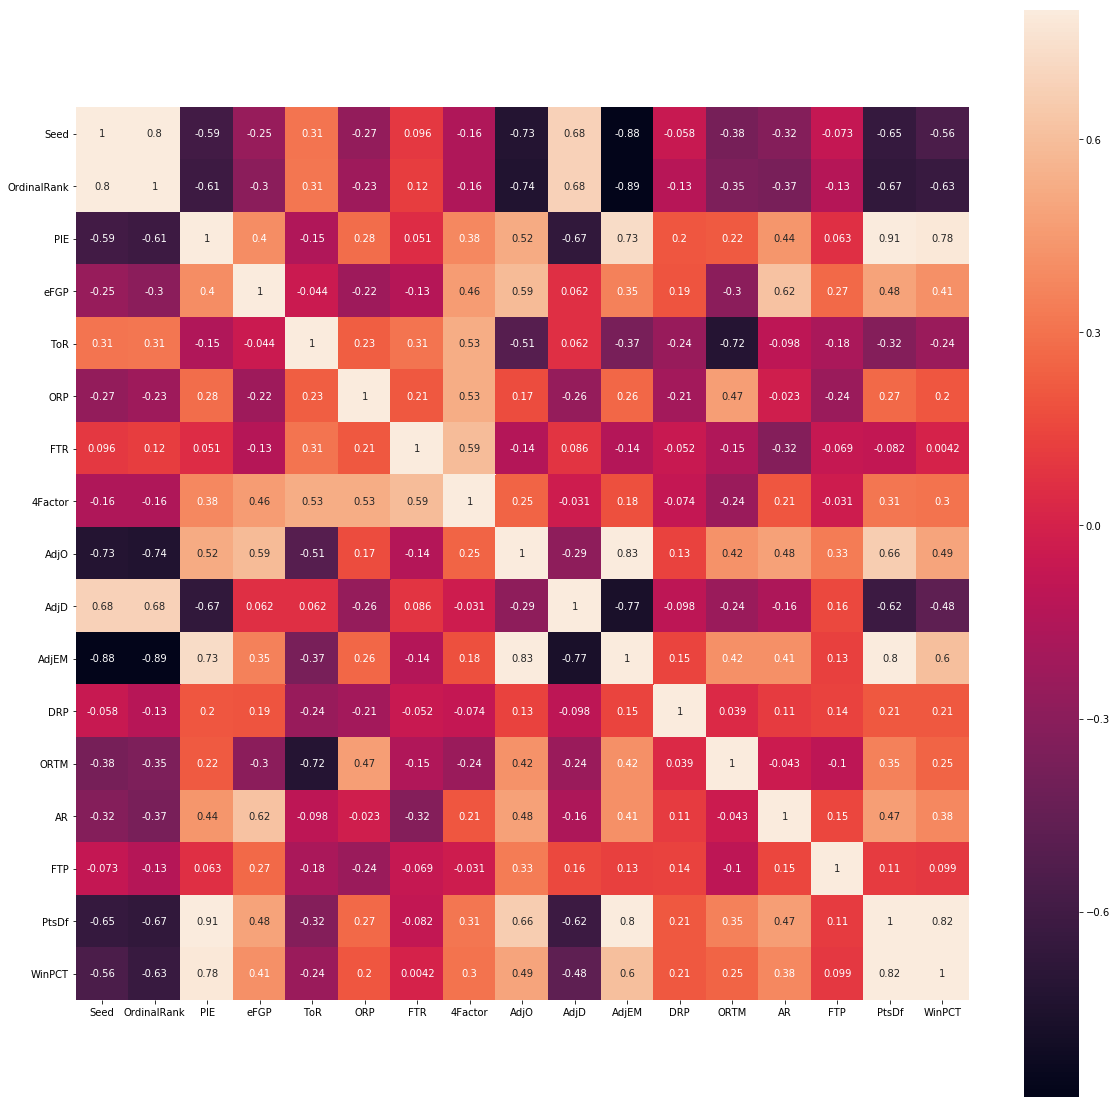

In [28]:
corrmatrix = df_tourney_final.iloc[:, 2:].corr()

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmatrix, vmax=0.8, annot=True, cbar=True, square=True)

### Create dataframe of features for winners in tournament since 2003

In [29]:
df_tourney.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tourney = df_tourney[df_tourney['Season'] > 2002]
df_tourney.reset_index(drop=True, inplace=True)
df_tourney.head()

,Season,WTeamID,LTeamID
0,2003,1421,1411
1,2003,1112,1436
2,2003,1113,1272
3,2003,1141,1166
4,2003,1143,1301


In [30]:
df_win_teams = pd.merge(left=df_tourney, right=df_tourney_final, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_win_teams.drop(labels='TeamID', inplace=True, axis=1)
df_win_teams.head()

,Season,WTeamID,LTeamID,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,2003,1421,1411,16,186,0.440672,0.489800,0.196965,0.347184,0.377214,0.371180,101.2,113.5,-12.35,0.625619,-3.931034,0.135985,0.766142,-7.241379,0.448276
1,2003,1112,1436,1,2,0.654693,0.517632,0.160953,0.394027,0.387965,0.384291,115.6,88.8,26.80,0.680560,0.392857,0.160719,0.701154,14.964286,0.892857
2,2003,1113,1272,10,32,0.585160,0.517334,0.170036,0.398080,0.468561,0.399343,113.9,97.4,16.49,0.683950,-0.310345,0.158358,0.675667,6.793103,0.620690
3,2003,1141,1166,11,44,0.569291,0.572835,0.223575,0.359177,0.481836,0.429139,109.5,99.4,10.01,0.662368,-7.655172,0.158267,0.762741,6.103448,0.793103
4,2003,1143,1301,8,33,0.556130,0.524098,0.173660,0.322310,0.348311,0.369763,109.9,96.3,13.59,0.692086,-2.931034,0.162401,0.688632,4.724138,0.724138


### Same for losers

In [31]:
df_loss_teams = pd.merge(left=df_tourney, right=df_tourney_final, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_loss_teams.drop(labels='TeamID', inplace=True, axis=1)
df_loss_teams.head()

,Season,WTeamID,LTeamID,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,2003,1421,1411,16,217,0.547692,0.503036,0.184551,0.360133,0.529491,0.398802,98.3,108.7,-10.45,0.681723,-2.066667,0.144831,0.613745,1.966667,0.600000
1,2003,1112,1436,16,144,0.561326,0.494732,0.180141,0.380016,0.356274,0.372372,101.1,99.5,1.57,0.732898,-1.103448,0.151546,0.649708,4.655172,0.655172
2,2003,1113,1272,7,26,0.597778,0.498337,0.163772,0.366803,0.396624,0.373132,110.9,94.1,16.72,0.683904,0.275862,0.164072,0.628299,8.689655,0.793103
3,2003,1141,1166,6,23,0.644084,0.567455,0.167750,0.339233,0.354147,0.389888,112.4,94.9,17.54,0.681826,-2.484848,0.171703,0.689707,14.909091,0.878788
4,2003,1143,1301,9,53,0.541945,0.534189,0.185834,0.308813,0.387496,0.380021,111.2,98.1,13.18,0.681661,-4.466667,0.158700,0.778148,4.400000,0.600000


### Create dataframe of winners - losers with added results column, merged to tourney matchups on the right

In [32]:
df_win_diff = df_win_teams.iloc[:, 3:] - df_loss_teams.iloc[:, 3:]
df_win_diff['result'] = 1
df_win_diff = pd.merge(left=df_win_diff, right=df_tourney, left_index=True, right_index=True, how='inner')
df_win_diff.head()

,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,-31,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,-0.027622,2.9,4.8,-1.90,-0.056104,-1.864368,-0.008846,0.152397,-9.208046,-0.151724,1,2003,1421,1411
1,-15,-142,0.093367,0.022900,-0.019188,0.014010,0.031691,0.011919,14.5,-10.7,25.23,-0.052338,1.496305,0.009173,0.051446,10.309113,0.237685,1,2003,1112,1436
2,3,6,-0.012618,0.018997,0.006264,0.031277,0.071937,0.026211,3.0,3.3,-0.23,0.000045,-0.586207,-0.005714,0.047369,-1.896552,-0.172414,1,2003,1113,1272
3,5,21,-0.074793,0.005381,0.055825,0.019944,0.127689,0.039251,-2.9,4.5,-7.53,-0.019458,-5.170324,-0.013436,0.073034,-8.805643,-0.085684,1,2003,1141,1166
4,-1,-20,0.014185,-0.010092,-0.012174,0.013497,-0.039185,-0.010259,-1.3,-1.8,0.41,0.010425,1.535632,0.003702,-0.089516,0.324138,0.124138,1,2003,1143,1301


### Same for losers

In [33]:
df_loss_diff = df_loss_teams.iloc[:, 3:] - df_win_teams.iloc[:, 3:]
df_loss_diff['result'] = 0
df_loss_diff = pd.merge(left=df_loss_diff, right=df_tourney, left_index=True, right_index=True, how='inner')
df_loss_diff.head()

,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,31,0.107021,0.013235,-0.012414,0.012949,0.152277,0.027622,-2.9,-4.8,1.90,0.056104,1.864368,0.008846,-0.152397,9.208046,0.151724,0,2003,1421,1411
1,15,142,-0.093367,-0.022900,0.019188,-0.014010,-0.031691,-0.011919,-14.5,10.7,-25.23,0.052338,-1.496305,-0.009173,-0.051446,-10.309113,-0.237685,0,2003,1112,1436
2,-3,-6,0.012618,-0.018997,-0.006264,-0.031277,-0.071937,-0.026211,-3.0,-3.3,0.23,-0.000045,0.586207,0.005714,-0.047369,1.896552,0.172414,0,2003,1113,1272
3,-5,-21,0.074793,-0.005381,-0.055825,-0.019944,-0.127689,-0.039251,2.9,-4.5,7.53,0.019458,5.170324,0.013436,-0.073034,8.805643,0.085684,0,2003,1141,1166
4,1,20,-0.014185,0.010092,0.012174,-0.013497,0.039185,0.010259,1.3,1.8,-0.41,-0.010425,-1.535632,-0.003702,0.089516,-0.324138,-0.124138,0,2003,1143,1301


### Create prediction set by concatenating winners and losers on top of each other, sorted by Season

In [34]:
prediction_dataset = pd.concat((df_win_diff, df_loss_diff), axis=0)
prediction_dataset.sort_values('Season', inplace=True)
prediction_dataset.head()

,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT,result,Season,WTeamID,LTeamID
0,0,-31,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,-0.027622,2.9,4.8,-1.90,-0.056104,-1.864368,-0.008846,0.152397,-9.208046,-0.151724,1,2003,1421,1411
28,11,46,-0.013858,-0.014261,0.011557,-0.052423,0.032148,-0.008478,-8.9,4.3,-13.24,0.027260,-3.586207,-0.002358,0.100614,-1.793103,-0.034483,0,2003,1393,1264
27,-1,9,0.082039,0.067915,0.003750,0.025868,-0.113316,0.016280,4.0,3.2,0.73,-0.004268,0.170507,0.039910,-0.103694,3.822581,0.034562,0,2003,1345,1261
26,13,95,-0.154728,-0.025687,-0.007815,0.001559,-0.096460,-0.026386,-10.1,19.7,-29.77,-0.032008,0.832258,-0.018119,0.083997,-11.669892,-0.189247,0,2003,1338,1447
25,5,37,0.032360,0.069025,-0.003349,-0.055668,-0.040919,0.009501,4.4,8.7,-4.32,0.091727,-1.390805,0.037968,0.036850,4.260536,0.125160,0,2003,1329,1335


## Part 2: Create and train the machine learning model
### Workflow:
* Create training set of data from 2013 and prior
* 2014-2017 data will be a true test set
* Split training set into a separate training and test set
* Initiate classifiers, create parameter and pipeline objects
* Use best performing classifer and fit with full training set
* Create data to input into the model
* Create predictions

### Split the dataframe into separate components

In [35]:
# For stage 1, label these as "labels", "features", and "ID's"

y = prediction_dataset['result']
X = prediction_dataset.loc[:, :'WinPCT']
train_IDs = prediction_dataset.loc[:, 'Season':]

In [36]:
X.head()

,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,0,-31,-0.107021,-0.013235,0.012414,-0.012949,-0.152277,-0.027622,2.9,4.8,-1.90,-0.056104,-1.864368,-0.008846,0.152397,-9.208046,-0.151724
28,11,46,-0.013858,-0.014261,0.011557,-0.052423,0.032148,-0.008478,-8.9,4.3,-13.24,0.027260,-3.586207,-0.002358,0.100614,-1.793103,-0.034483
27,-1,9,0.082039,0.067915,0.003750,0.025868,-0.113316,0.016280,4.0,3.2,0.73,-0.004268,0.170507,0.039910,-0.103694,3.822581,0.034562
26,13,95,-0.154728,-0.025687,-0.007815,0.001559,-0.096460,-0.026386,-10.1,19.7,-29.77,-0.032008,0.832258,-0.018119,0.083997,-11.669892,-0.189247
25,5,37,0.032360,0.069025,-0.003349,-0.055668,-0.040919,0.009501,4.4,8.7,-4.32,0.091727,-1.390805,0.037968,0.036850,4.260536,0.125160


### Split components into 2003-2013 and 2014-2017 sets
#### Skip for stage 2

In [ ]:
# Identify numerical key at bottom row of 2003-2013 set
# len(prediction_dataset[prediction_dataset['Season'] < 2014])

In [ ]:
# Create 2014-2017 test set

# test_labels = prediction_dataset['result'][prediction_dataset['Season'] > 2013]
# test_features = prediction_dataset.iloc[1426:, :15]
# test_IDs = prediction_dataset.iloc[1426:, 16:]

In [ ]:
# Create the 2003-2013 training set

# y = prediction_dataset['result'][prediction_dataset['Season'] < 2014]
# X = prediction_dataset.iloc[:1426, :15]
# train_IDs = prediction_dataset.iloc[:1426, 16:]

In [37]:
# Split the 2003-2013 set even further

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=1, stratify=y)

In [41]:
# Initiate classifiers

clf1 = LogisticRegression()
clf2 = KNeighborsClassifier()                             
clf3 = XGBClassifier()
clf4 = DecisionTreeClassifier() 
clf5 = RandomForestClassifier()
clf6 = GradientBoostingClassifier()

In [42]:
# Configure Parameter grids

param_grid1 = [{'clf1__C': list(np.logspace(start=-5, stop=3, num=9))}]

param_grid2 = [{'clf2__n_neighbors': list(range(1, 20)),
                'clf2__p': [1, 2],
                'clf2__algorithm': ['ball_tree', 'kd_tree']}]

param_grid3 = [{'learning_rate' : [0.1, 0.3],
                'max_depth': [3, 6],
                'min_child_weight': list(range(1, 3))}]

param_grid4 = [{'max_depth': list(range(3, 6)),
                'criterion': ['gini', 'entropy'],
                'min_samples_leaf': [20, 50]}]

param_grid5 = [{'max_depth': list(range(1, 5)),
                'criterion': ['gini', 'entropy'],
                'min_samples_split' : [2, 3]}]

param_grid6 = [{'learning_rate' : [0.01, 0.1],
                'loss' : ['deviance','exponential'],
                'max_depth': list(range(3, 4))}]

In [43]:
# Build the pipelines

pipe1 = Pipeline([('clf1', clf1)])

pipe2 = Pipeline([('clf2', clf2)])

pipe3 = Pipeline([('clf3', clf3)])

pipe4 = Pipeline([('clf4', clf4)])

pipe5 = Pipeline([('clf5', clf5)])

pipe6 = Pipeline([('clf6', clf6)])

In [45]:
# Set up GridSearchCV objects, one for each algorithm

gridcvs = {}

inner_cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=2)
outer_cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=2)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4,
                             param_grid5, param_grid6),
                            (pipe1, pipe2, clf3, clf4, clf5, clf6),
                            ('Logistic', 'KNN', 'XGBoost', 'DTree', 'Random Forest', 'Gradient Boosting')):

# First loop runs GridSearch and does Cross validation to find the best parameters

    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='neg_log_loss',
                       cv=outer_cv,
                       verbose=0,
                       refit=True,
                       return_train_score=False)
    
    gcv.fit(X_train, y_train)
    
    gridcvs[name] = gcv
    
    print(name)
    print()
    print(gcv.best_estimator_)
    print()
    print('Best score on Grid Search Cross Validation is %.2f%%' % (gcv.best_score_))
    print()
    results = pd.DataFrame(gcv.cv_results_)
      

#Inner loop runs Cross Val Score on tuned parameter model to determine accuracy of fit        

    # for name, gs_est in sorted(gridcvs.items()):
    
    nested_score = 0
    nested_score = cross_val_score(gcv, 
                                  X=X_train, 
                                  y=y_train, 
                                  cv=inner_cv,
                                  scoring='neg_log_loss')
                                
    
    print('Name, Log Loss, Std Dev, based on Best Parameter Model using Cross Validation Scoring')
    print('%s | %.2f %.2f' % (name,  nested_score.mean(),  nested_score.std() * 100,))
    print()
    
    
#Generate predictions and probabilities
    
    best_algo = gcv    

    best_algo.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_true=y_train, y_pred=best_algo.predict(X_train))
    test_acc = accuracy_score(y_true=y_test, y_pred=best_algo.predict(X_test))
 
    print('Training Accuracy: %.2f%%' % (100 * train_acc))
    print('Test Accuracy: %.2f%%' % (100 * test_acc))
    print()
    
# prints classification report and confusion matrix
    
    if name != 'SVM':
        
        predictions = best_algo.predict(X_test)
        probability = best_algo.predict_proba(X_test)
        print(classification_report(y_test,predictions))
        print()
        print(confusion_matrix(y_test,predictions))
        print()
        
    else:
        print()

Logistic

Pipeline(memory=None,
     steps=[('clf1', LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Best score on Grid Search Cross Validation is -0.46%

Name, Log Loss, Std Dev, based on Best Parameter Model using Cross Validation Scoring
Logistic | -0.46 4.77

Training Accuracy: 78.95%
Test Accuracy: 79.80%

             precision    recall  f1-score   support

          0       0.81      0.78      0.79       294
          1       0.79      0.81      0.80       295

avg / total       0.80      0.80      0.80       589


[[230  64]
 [ 55 240]]

KNN

Pipeline(memory=None,
     steps=[('clf2', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform'))])

Bes

/home/mr_robot/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mr_robot/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mr_robot/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training Accuracy: 87.47%
Test Accuracy: 74.87%

             precision    recall  f1-score   support

          0       0.76      0.73      0.74       294
          1       0.74      0.77      0.75       295

avg / total       0.75      0.75      0.75       589


[[215  79]
 [ 69 226]]

DTree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Best score on Grid Search Cross Validation is -0.53%

Name, Log Loss, Std Dev, based on Best Parameter Model using Cross Validation Scoring
DTree | -0.53 7.13

Training Accuracy: 75.53%
Test Accuracy: 76.40%

             precision    recall  f1-score   support

          0       0.79      0.71      0.75       294
          1       0.74      0.81      0

In [72]:
# Initialize classifier and fit data

# clf = LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100,
#                          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
#                          verbose=0, warm_start=False)

# clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1,
#                            n_neighbors=19, p=2, weights='uniform')

# clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=1, gamma=0,
#                     learning_rate=0.1, max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
#                     n_estimators=100, n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)

# clf = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3, max_features=None, max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=50, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')

# clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=4, max_features='auto',
#                              max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1,
#                              min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False,
#                              random_state=None, verbose=0, warm_start=False)

clf = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=3,
                                 max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                 presort='auto', random_state=None, subsample=1.0, verbose=0, warm_start=False)

# clf = LinearSVC(dual=False, C=10.0)

clf.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [47]:
# Create data to input into the model

n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

X_test = np.zeros(shape=(n_test_games, 1))
columns = df_tourney_final.columns.get_values()
model = []
data = []

for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    
    team1 = df_tourney_final[(df_tourney_final.TeamID == t1) & (df_tourney_final.Season == year)].values
    team2 = df_tourney_final[(df_tourney_final.TeamID == t2) & (df_tourney_final.Season == year)].values
    
    model = team1 - team2
    
    data.append(model)
    
Predictions = pd.DataFrame(np.array(data).reshape(2278,19), columns = (columns))

Predictions.drop(labels=['Season', 'TeamID'], inplace=True, axis=1)

Predictions.head()

,Seed,OrdinalRank,PIE,eFGP,ToR,ORP,FTR,4Factor,AdjO,AdjD,AdjEM,DRP,ORTM,AR,FTP,PtsDf,WinPCT
0,5.0,40.0,-0.076246,-0.052636,0.021071,-0.040228,0.033906,-0.018746,-9.4,-5.1,-4.35,-0.054736,-1.852941,-0.027284,-0.081878,-7.323529,-0.235294
1,-2.0,-1.0,-0.028141,-0.023935,0.046794,0.007669,-0.010167,0.002133,-8.1,-7.3,-0.82,0.006590,-3.311195,-0.011280,-0.075078,-5.811195,-0.086338
2,2.0,28.0,-0.005354,-0.022959,0.042795,-0.005134,0.038708,0.006294,-7.7,-6.4,-1.28,0.018321,-3.294118,-0.013786,0.008480,-3.176471,-0.117647
3,5.0,50.0,-0.040036,-0.003433,0.033189,-0.037069,0.019132,0.002380,-6.8,-1.5,-5.29,-0.020867,-3.992647,-0.009352,-0.107709,-7.680147,-0.222426
4,-5.0,-26.0,-0.043437,-0.026643,0.024791,0.017907,-0.010216,-0.002411,-0.8,-7.0,6.21,-0.024573,-0.852941,-0.014950,-0.038146,-5.911765,-0.176471


In [73]:
# Generate the predictions

# preds = clf.predict(Predictions)
preds = clf.predict_proba(Predictions)[:,1]

df_sample_sub['Pred'] = preds
df_sample_sub.head()

,ID,Pred
0,2018_1104_1112,0.438796
1,2018_1104_1113,0.352291
2,2018_1104_1116,0.338818
3,2018_1104_1120,0.362255
4,2018_1104_1137,0.719037


In [74]:
# Generate prediction file

# df_sample_sub.to_csv('Predictions/2018_predictions_lr.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_knn.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_xgb.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_dtree.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_rf.csv', index=False)
df_sample_sub.to_csv('Predictions/2018_predictions_gb.csv', index=False)
# df_sample_sub.to_csv('Predictions/2018_predictions_lsvc.csv', index=False)

In [75]:
def build_team_dict():
    team_ids = pd.read_csv('Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['TeamID']] = row['TeamName']
    return team_id_map
team_id_map = build_team_dict()
readable = []
less_readable = []  # A version that's easy to look up.
submission_data = df_sample_sub.values.tolist()
for pred in submission_data:
    parts = pred[0].split('_')
    less_readable.append(
        [team_id_map[int(parts[1])], team_id_map[int(parts[2])], pred[1]])
    # Order them properly.
    if pred[1] > 0.5:
        winning = int(parts[1])
        losing = int(parts[2])
        proba = pred[1]
    else:
        winning = int(parts[2])
        losing = int(parts[1])
        proba = 1 - pred[1]
    readable.append(
        [
            '%s beats %s: %f' %
            (team_id_map[winning], team_id_map[losing], proba)
        ]
    )

In [76]:
Finalpredictions=pd.DataFrame(readable)
Finalpredictions.to_csv("GB_predictions.csv", index=False)